# Cloudant Python Notebook Example

This is an example Python Notebook that showcases how to use the sql-cloudant connector. The notebook shows how to:
* Connect Spark to a Cloudant database
* Read and show the schema and data of the JSON documents
* Use SparkSQL to query the data
* Graph the data in a chart
* Filter the data and save in your own Cloudant database

## Useful links

* [Cloudant](https://console.ng.bluemix.net/catalog/services/cloudant-nosql-db/) on Bluemix
* [Apache Spark-aaS](https://console.ng.bluemix.net/catalog/services/apache-spark/) on Bluemix
* [Data Science Experience](https://datascience.ibm.com) on Bluemix
* [Apache Bahir sql-cloudant](https://github.com/cloudant-labs/spark-cloudant) Connector
* Example Cloudant Database: https://examples.cloudant.com/spark_sales



In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Connect to database 'spark_sales' and read schema using _all_docs endpoint
# Note: _all_docs endpoint is the default load setting.

cloudantdata = spark.read.format("org.apache.bahir.cloudant")\
.option("cloudant.host","examples.cloudant.com")\
.load("spark_sales")

# Create Spark session for reading Cloudant data using the _changes endpoint
# Read more about when to consider using the _changes endpoint: https://github.com/apache/bahir/blob/master/sql-cloudant/README.md
# Note: use "spark.streaming.unpersist=false" to persist RDDs throughout the load process.  

# spark = SparkSession\
#     .builder\
#     .config("cloudant.host", "examples.cloudant.com")\
#     .config("cloudant.endpoint", "_changes")\
#     .config("spark.streaming.unpersist", "false")\
#     .getOrCreate()

# cloudantdata = spark.read.format("org.apache.bahir.cloudant")\
# .option("cloudant.host","examples.cloudant.com")\
# .option("cloudant.endpoint", "_changes")\
# .option("spark.streaming.unpersist", "false")\
# .load("spark_sales")

# Print the schema that was detected
cloudantdata.printSchema()

# Cache the data
cloudantdata.cache()

root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- amount: long (nullable = true)
 |-- month: string (nullable = true)
 |-- rep: string (nullable = true)



DataFrame[_id: string, _rev: string, amount: bigint, month: string, rep: string]

In [2]:
# Count Data
print "Count is {0}".format(cloudantdata.count())

Count is 2022


In [3]:
# Print Data

# Show 20 as default
cloudantdata.show()

# Show 5
cloudantdata.show(5)

# Show the rep field for 5
cloudantdata.select("rep").show(5)

+--------------------+--------------------+-------+--------+---------+
|                 _id|                _rev| amount|   month|      rep|
+--------------------+--------------------+-------+--------+---------+
|0c6d783c1f9164354...|1-23dd4ecb8b93c4b...|8057513|    June|   Ashley|
|0c6d783c1f9164354...|1-9a4b9529f635f16...|8353677| January|   Ashley|
|0c6d783c1f9164354...|1-a508cfb9d1f2b96...|7065940|    June|     Evan|
|0c6d783c1f9164354...|1-faa26d7740ed5df...|9326574|    June|     Evan|
|0c6d783c1f9164354...|1-9b9300506cfcd4f...|4578691|December|   Ashley|
|0c6d783c1f9164354...|1-67df9938ffde7da...|9430766|   March|    Bella|
|0c6d783c1f9164354...|1-247cc348b494dc1...|9510494|   April|   Nathan|
|0c6d783c1f9164354...|1-5bc9db6e32ad584...|5676165|    July|Charlotte|
|0c6d783c1f9164354...|1-66d253978572afd...|2761221|    June|Charlotte|
|0c6d783c1f9164354...|1-274b3e1b7746dcb...|9658504| October|   Ashley|
|0c6d783c1f9164354...|1-4e1c44d2cb529e7...|7794029| January|   Nathan|
|0c6d7

In [4]:
# Run SparkSQL to get COUNTs and SUMs and do ORDER BY VALUE examples

# Register a temp table sales_table on the cloudantdata data frame
cloudantdata.registerTempTable("sales_table")

# Run SparkSQL to get a count and total amount of sales by rep
sqlContext.sql("SELECT rep AS REP, COUNT(amount) AS COUNT, SUM(amount) AS AMOUNT FROM sales_table GROUP BY rep ORDER BY SUM(amount) DESC").show(100)

# Run SparkSQL to get total amount of sales by month
sqlContext.sql("SELECT month AS MONTH, SUM(amount) AS AMOUNT FROM sales_table GROUP BY month ORDER BY SUM(amount) DESC").show()

+---------+-----+----------+
|      REP|COUNT|    AMOUNT|
+---------+-----+----------+
|Charlotte|  408|2150072136|
|   Nathan|  399|2128777269|
|     Evan|  403|2122787250|
|   Ashley|  406|2109849878|
|    Bella|  406|2091567518|
+---------+-----+----------+

+---------+----------+
|    MONTH|    AMOUNT|
+---------+----------+
|     June|1006655547|
|    March| 965554387|
| February| 949894161|
|      May| 895723365|
|  January| 883823633|
|     July| 881441469|
|  October| 879310075|
|   August| 866259553|
|    April| 851319642|
|September| 838826558|
| November| 795484324|
| December| 788761337|
+---------+----------+



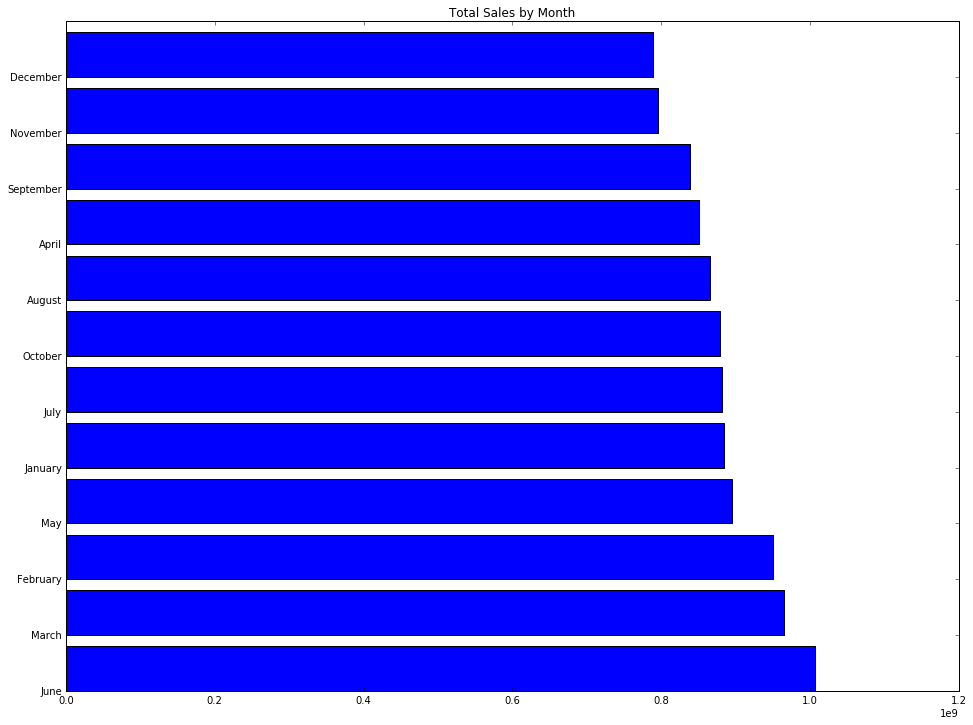

In [5]:
# Graph the Monthly Sales  

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pandaDF = sqlContext.sql("SELECT month AS MONTH, SUM(amount) AS AMOUNT FROM sales_table GROUP BY month ORDER BY SUM(amount) DESC").toPandas()
values = pandaDF['AMOUNT']
labels = pandaDF['MONTH']
plt.gcf().set_size_inches(16, 12, forward=True)
plt.title('Total Sales by Month')
plt.barh(range(len(values)), values)
plt.yticks(range(len(values)), labels)
plt.show()

In [6]:
# Filter, Count, Show, and Save Data

# Filter data for the rep 'Charlotte' and month of 'September'
filteredCloudantData = cloudantdata.filter("rep = 'Charlotte' AND month = 'September'")

# Count filtered data
print "Total Count is {0}".format(filteredCloudantData.count())

# Show filtered data
filteredCloudantData.show(5)

Total Count is 33
+--------------------+--------------------+-------+---------+---------+
|                 _id|                _rev| amount|    month|      rep|
+--------------------+--------------------+-------+---------+---------+
|0c6d783c1f9164354...|1-29e336f06e3f031...|4040415|September|Charlotte|
|0c6d783c1f9164354...|1-03033ae617f6bf9...|7391421|September|Charlotte|
|647dce3993599dbd1...|1-ec9322134c75ed4...|4054322|September|Charlotte|
|647dce3993599dbd1...|1-ca8ab5bf6217ec2...|4517007|September|Charlotte|
|647dce3993599dbd1...|1-275d7d2f358072b...|8692972|September|Charlotte|
+--------------------+--------------------+-------+---------+---------+
only showing top 5 rows



In [7]:
# Saving the amount, month, and rep fields from the filtered data to a new Cloudant database 'sales_charlotte_september'
filteredCloudantData.select("amount","month","rep").write.format("org.apache.bahir.cloudant")\
.option("cloudant.host","USERNAME.cloudant.com")\
.option("cloudant.username", "USERNAME")\
.option("cloudant.password","PASSWORD")\
.option("createDBOnSave", "true")\
.save("sales_charlotte_september")